Total infections: 381
Initial seed infections: 2
Secondary infections: 379

=== GENERATION ANALYSIS ===
Sample generations: {'SEED': 0, 3: 1, 4: 1, 27: 2, 36: 2, 47: 2, 12: 2, 44: 2, 15: 2, 67: 2}
Total nodes in graph: 125
Total edges in graph: 361
Nodes connected to SEED: [3, 4]
Generation counts: {1: 2, 2: 13, 3: 23, 4: 20, 5: 2, 6: 1}
Infections by generation:
Generation 1: 2 people
Generation 2: 13 people
Generation 3: 23 people
Generation 4: 20 people
Generation 5: 2 people
Generation 6: 1 people


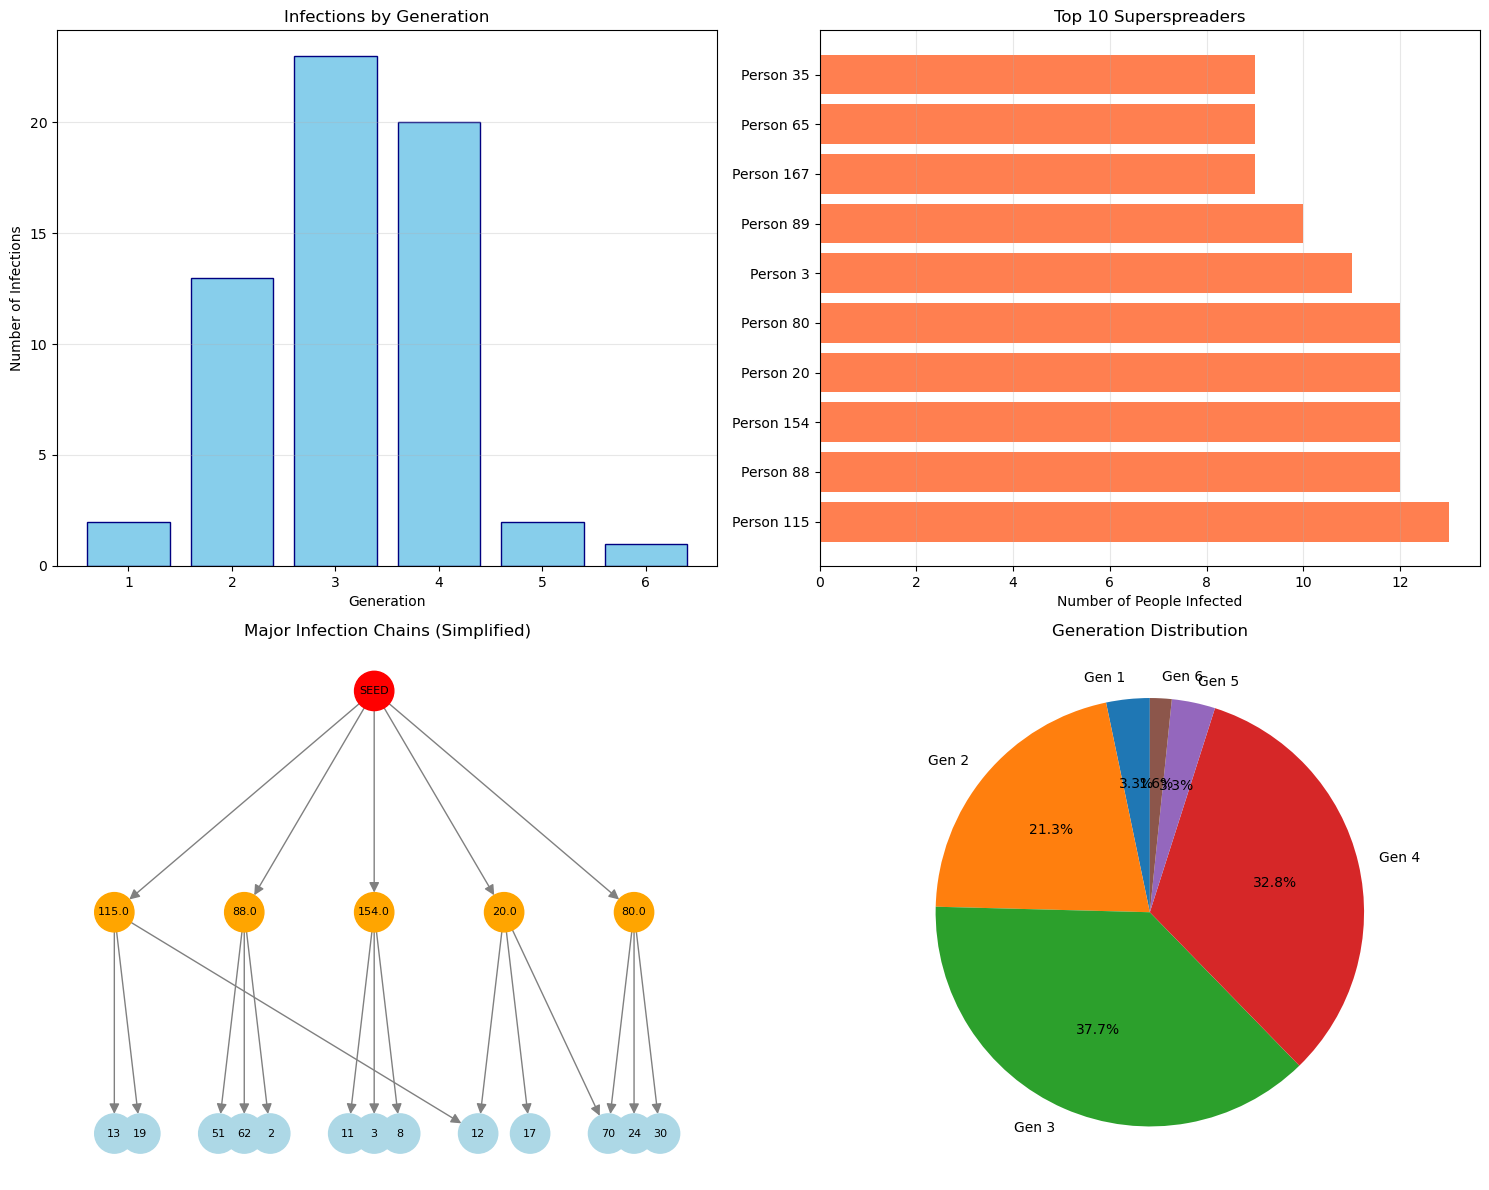

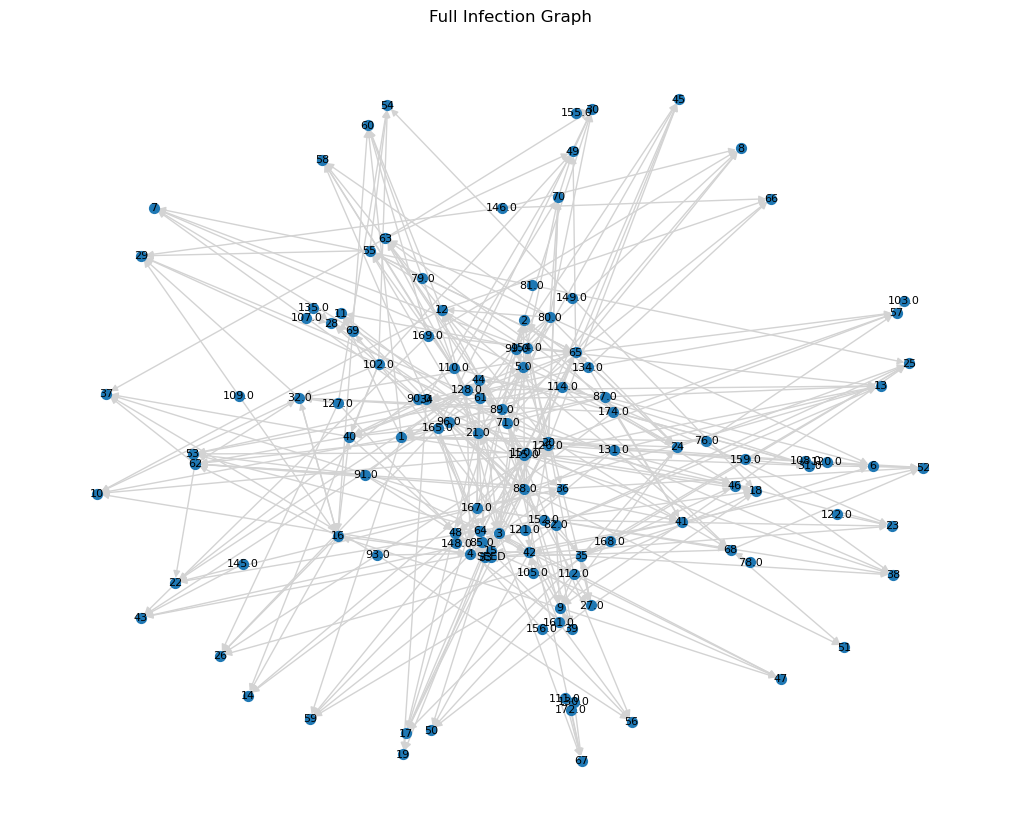


=== SUMMARY ===
Total people infected: 381
Initial seeds: 2
Maximum generation reached: 6
Biggest superspreader infected: 13 people
Average infections per spreader: 3.9


In [27]:
# Generate clean infection chain analysis for simulation data

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from collections import defaultdict

# Read the CSV file
df = pd.read_csv("../data/raw/sample_2/infection_logs.csv")
print(f"Total infections: {len(df)}")

# Basic statistics
initial_infections = df['infector_person_id'].isna().sum()
print(f"Initial seed infections: {initial_infections}")
print(f"Secondary infections: {len(df) - initial_infections}")

# Create multiple visualizations for better understanding

# 1. INFECTION GENERATION ANALYSIS
print("\n=== GENERATION ANALYSIS ===")
G = nx.DiGraph()

# Build the graph
for _, row in df.iterrows():
    infector = row['infector_person_id']
    infected = row['infected_person_id']
    
    if pd.isna(infector):
        infector = 'SEED'
    
    G.add_edge(infector, infected)

# Calculate generations using BFS
from collections import deque

generations = {}
queue = deque([('SEED', 0)])
generations['SEED'] = 0

while queue:
    node, gen = queue.popleft()
    for successor in G.successors(node):
        if successor not in generations:
            generations[successor] = gen + 1
            queue.append((successor, gen + 1))

print(f"Sample generations: {dict(list(generations.items())[:10])}")

# Debug: Check if we have any nodes
print(f"Total nodes in graph: {G.number_of_nodes()}")
print(f"Total edges in graph: {G.number_of_edges()}")
print(f"Nodes connected to SEED: {list(G.successors('SEED'))[:5]}")

# Count by generation
gen_counts = defaultdict(int)
for person, gen in generations.items():
    if person != 'SEED':
        gen_counts[gen] += 1

print(f"Generation counts: {dict(gen_counts)}")

print("Infections by generation:")
for gen in sorted(gen_counts.keys()):
    print(f"Generation {gen}: {gen_counts[gen]} people")

# 2. VISUALIZATION: Generation bar chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Generation distribution
if len(gen_counts) > 0:
    gens = list(gen_counts.keys())
    counts = [gen_counts[g] for g in gens]
    ax1.bar(gens, counts, color='skyblue', edgecolor='navy')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Number of Infections')
    ax1.set_title('Infections by Generation')
    ax1.grid(axis='y', alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No generation data found\nCheck your data structure', 
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('Infections by Generation - No Data')

# 3. Top superspreaders
infector_counts = df.groupby('infector_person_id').size().sort_values(ascending=False)
infector_counts = infector_counts.dropna()  # Remove NaN (initial seeds)

if len(infector_counts) > 0:
    top_spreaders = infector_counts.head(10)
    ax2.barh(range(len(top_spreaders)), top_spreaders.values, color='coral')
    ax2.set_yticks(range(len(top_spreaders)))
    ax2.set_yticklabels([f'Person {int(id)}' for id in top_spreaders.index])
    ax2.set_xlabel('Number of People Infected')
    ax2.set_title('Top 10 Superspreaders')
    ax2.grid(axis='x', alpha=0.3)

# 4. Simplified tree (sample of major chains)
# Get the biggest infection chains
major_chains = infector_counts.head(5).index if len(infector_counts) > 0 else []

G_simple = nx.DiGraph()
G_simple.add_node('SEED')

# Add major spreaders and their immediate connections
for spreader in major_chains:
    G_simple.add_edge('SEED', spreader)
    # Add some of their infections
    infected_by_spreader = df[df['infector_person_id'] == spreader]['infected_person_id'].head(3)
    for infected in infected_by_spreader:
        G_simple.add_edge(spreader, infected)

# Position nodes for tree layout
pos = {}
pos['SEED'] = (0, 2)

# Position major spreaders
if len(major_chains) > 0:
    spread = 4
    start_x = -(len(major_chains) - 1) * spread / 2
    for i, spreader in enumerate(major_chains):
        pos[spreader] = (start_x + i * spread, 1)
        
        # Position their infections
        infected_by_spreader = df[df['infector_person_id'] == spreader]['infected_person_id'].head(3)
        for j, infected in enumerate(infected_by_spreader):
            pos[infected] = (start_x + i * spread + (j-1) * 0.8, 0)

# Draw simplified tree
if len(pos) > 1:
    node_colors = ['red' if n == 'SEED' else 'orange' if n in major_chains else 'lightblue' 
                   for n in G_simple.nodes()]
    
    nx.draw_networkx(G_simple, pos, ax=ax3,
                    with_labels=True, 
                    node_color=node_colors,
                    node_size=800,
                    font_size=8,
                    arrowsize=15,
                    edge_color='gray')
    ax3.set_title('Major Infection Chains (Simplified)')
    ax3.axis('off')

# 5. Infection timeline (if timestamp available)
if 'timestamp' in df.columns:
    time_col = 'timestamp'
    daily_infections = df.groupby(time_col).size()
    ax4.plot(daily_infections.index, daily_infections.values, marker='o', linewidth=2, markersize=4)
    ax4.set_xlabel('Time')
    ax4.set_ylabel('New Infections')
    ax4.set_title('Infection Timeline')
    ax4.grid(alpha=0.3)
else:
    # Show distribution of generation sizes as pie chart
    ax4.pie(counts, labels=[f'Gen {g}' for g in gens], autopct='%1.1f%%', startangle=90)
    ax4.set_title('Generation Distribution')

plt.tight_layout()

# 6. Full Infection Graph 
plt.figure(figsize=(10, 8))
pos_full = nx.spring_layout(G, seed=42)
nx.draw(G, pos_full, with_labels=True, node_size=50, font_size=8, edge_color='lightgray')
plt.title('Full Infection Graph')
plt.show()

# Print summary statistics
print(f"\n=== SUMMARY ===")
print(f"Total people infected: {len(df)}")
print(f"Initial seeds: {initial_infections}")
print(f"Maximum generation reached: {max(gen_counts.keys()) if gen_counts else 0}")
if len(infector_counts) > 0:
    print(f"Biggest superspreader infected: {infector_counts.iloc[0]} people")
    print(f"Average infections per spreader: {infector_counts.mean():.1f}")